### Import the required modules
- `sklearn` &mdash; machine learning library
- `h5py` &mdash; to read .hdf5 datasets
- `os` &mdash; to manipulate pathways
- `numpy` &mdash; to manipuilate arrays
- `matplotlib` &mdash; to visualise data
- `tqdm` &mdash; to make progress bars
- `pickle` &mdash; a module for serializing python objects as byte streams, which is useful for saving machine learning models created with `sklearn` (and other objects, of course)

In [23]:
import sklearn
import h5py
import os
import numpy as np
from sklearn import ensemble
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

### Define constants and access the datasets

In [2]:
DATA_DIR = os.path.join("<path>", "<to>", "<data>")
TRAIN_DATASET_PATH = os.path.join(DATA_DIR, "train_dataset.hdf5")
VAL_DATASET_PATH = os.path.join(DATA_DIR, "val_dataset.hdf5")
TEST_DATASET_PATH = os.path.join(DATA_DIR, "test_dataset.hdf5")

MODEL_PATH = "random_forest"

In [3]:
SAMPLES_PER_TILE = 1000
BANDS_COUNT = 10

In [4]:
train_dataset = h5py.File(TRAIN_DATASET_PATH, "r")
val_dataset = h5py.File(VAL_DATASET_PATH, "r")
test_dataset = h5py.File(TEST_DATASET_PATH, "r")

### Data access
Define a helper function `get_images_stack` that reads different features and groundtruth from a group and stacks them together. Note that not all tiles share common sets of features completely

In [6]:
def get_images_stack(tile_data):
    optical = tile_data["optical"]
    height, width, _ = optical.shape
    stack = np.empty((height, width, BANDS_COUNT + 1))
    stack[:, :, 0:6] = optical

    dem = tile_data["dem"]
    stack[:, :, 6] = dem[:, :, 0]
    slope = tile_data["slope"]
    stack[:, :, 7] = slope[:, :, 0]

    co_pol_intensity_asc = tile_data["co_pol_intensity_asc"]
    stack[:, :, 8] = co_pol_intensity_asc[:, :]
    co_pol_intensity_desc = tile_data["co_pol_intensity_desc"]
    stack[:, :, 9] = co_pol_intensity_desc[:, :]

    groundtruth = tile_data["groundtruth"]
    stack[:, :, -1] = groundtruth[:, :, 0]
    
    return stack

And to form the training dataset that will be used directly for the training, extract `SAMPLES_PER_TILE` pixels from every tile.

In [13]:
def extract_features_and_labels(dataset):
    xs, ys = [], []
    
    with tqdm(total=len(dataset.keys())) as pbar:
        for group in dataset.keys():
            tile_data = dataset[group]
            if "groundtruth" not in tile_data.keys():
                pbar.update(1)
                continue

            stack = get_images_stack(tile_data)
            height, width, _ = stack.shape
            stack = stack.reshape((height * width, BANDS_COUNT + 1))
            sample_idxs = np.random.choice(stack.shape[0], size=SAMPLES_PER_TILE, replace=False)
            samples = stack[sample_idxs]

            xs.extend(samples[:, :-1])
            ys.extend(samples[:, -1])

            pbar.update(1)

    ys = [int(_) for _ in ys]
    return xs, ys

In [8]:
train_x, train_y = extract_features_and_labels(train_dataset)

100%|███████████████████████████████████████████████████████████████| 495/495 [07:24<00:00,  1.11it/s]


### Model definition and training
To create a random forest model, simply use a ready-to-use class from `sklearn`. Feel free to explore more options at https://scikit-learn.org/stable/supervised_learning.html

In [21]:
classifier = ensemble.RandomForestClassifier(
    n_jobs=-1, 
    # verbose=11
)

Training is done by calling the `fit` method.

In [14]:
classifier.fit(train_x, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    2.9s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s


building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    5.7s


building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    5.9s


building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    6.2s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    8.3s


building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s


building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    8.9s


building tree 64 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    9.0s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:   11.0s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   11.3s


building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.4s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   11.8s


building tree 79 of 100
building tree 80 of 100


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.8s


building tree 81 of 100


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   13.7s


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.1s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100


[Parallel(n_jobs=-1)]: Done  79 out of 100 | elapsed:   14.8s remaining:    3.9s


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  89 out of 100 | elapsed:   17.1s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished


RandomForestClassifier(n_jobs=-1, verbose=11)

And after the training, you can evaluate the model on the training set just to make sure that there was no problem with the workflow before.

In [15]:
classifier.score(train_x, train_y)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  15 tasks      | elaps

0.9999933184855234

You can save your model and load it back as follows.

In [16]:
pickle.dump(classifier, open(MODEL_PATH, "wb"))

In [17]:
classifier = pickle.load(open(MODEL_PATH, "rb"))

### Test tile classification and reporting model performance
To classify test tiles, we reshape them in the shape of `(n_pixels, n_features)`, feed them to the classifier and reshape them back. For each tile, we keep track of the values of `TP`, `TN`, `FP` and `FN` to calculate the metrics showing the model performance:

$Precision = \frac{TP}{TP + FP} , $

$Recall = \frac{TP}{TP + FN} , $

$F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall} , $

$IoU = \frac{TP}{TP + FP + FN} . $

In [18]:
results = {}

with tqdm(total=len(test_dataset.keys())) as pbar:
    for group in test_dataset.keys():
        tile_data = test_dataset[group]
        if "groundtruth" not in tile_data.keys():
            pbar.update(1)
            continue

        stack = get_images_stack(tile_data)
        height, width, _ = stack.shape
        features = stack[:, :, :BANDS_COUNT]
        features = features.reshape((height * width, BANDS_COUNT))
        
        prediction = classifier.predict(features)
        prediction = prediction.reshape((height, width))
        results[group] = prediction
                            
        pbar.update(1)

  0%|                                                                         | 0/178 [00:00<?, ?it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(

[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished
  1%|▋                                                                | 2/178 [00:01<02:38,  1.11it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Paralle

  8%|█████▍                                                          | 15/178 [00:13<02:36,  1.04it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(

[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
 10%|██████                                                          | 17/178 [00:14<02:12,  1.22it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      |

[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapse

[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished
 12%|███████▌                                                        | 21/178 [00:17<01:47,  1.45it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 

[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.2s
[Paralle

[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.1s
[Paralle

[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished
 18%|███████████▌                                                    | 32/178 [00:25<01:37,  1.49it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished
 19%|████████████▏                                                   | 34/178 [00:26<01:43,  1.39it/s][Parallel(n_jobs=16)]: Using backend Threadin

[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.2s
[Paralle

 25%|████████████████▏                                               | 45/178 [00:34<01:37,  1.37it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(

[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished
 26%|████████████████▉                                               | 47/178 [00:36<01:31,  1.43it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Paralle

 31%|████████████████████▏                                           | 56/178 [00:43<01:39,  1.23it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(

[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.6s remainin

[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Paralle

 39%|████████████████████████▊                                       | 69/178 [00:51<00:58,  1.85it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(

[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.8s finished
 41%|██████████████████████████▏                                     | 73/178 [00:53<00:52,  2.01it/s][Parallel(n_jobs=16)]: Using backend Threadin

[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Paralle

 49%|███████████████████████████████▎                                | 87/178 [00:59<00:43,  2.11it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(

[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished
 51%|████████████████████████████████▋                               | 91/178 [01:01<00:40,  2.15it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.2s
[Paralle

[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished
 60%|█████████████████████████████████████▌                         | 106/178 [01:11<01:07,  1.06it/s][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 

[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.3s
[Paralle

[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.3s finished
 66%|█████████████████████████████████████████▍                     | 117/178 [01:26<01:24,  1.38s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished
 67%|██████████████████████████████████████████                     | 119/178 [01:29<01:19,  1.35s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.0s finished
 72%|█████████████████████████████████████████████▎                 | 128/178 [01:41<01:06,  1.33s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  11 tasks      |

[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Paralle

[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Paralle

 77%|████████████████████████████████████████████████▍              | 137/178 [01:52<00:47,  1.17s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(

[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished
 78%|█████████████████████████████████████████████████▏             | 139/178 [01:54<00:47,  1.22s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.5s
[Paralle

[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.4s
[Paralle

[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.2s finished
 84%|█████████████████████████████████████████████████████          | 150/178 [02:08<00:36,  1.29s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.2s finished
 85%|█████████████████████████████████████████████████████▊         | 152/178 [02:11<00:34,  1.34s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  41 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  15 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Paralle

 89%|████████████████████████████████████████████████████████▎      | 159/178 [02:20<00:22,  1.21s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(

[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished
 90%|████████████████████████████████████████████████████████▉      | 161/178 [02:23<00:21,  1.27s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished
 92%|█████████████████████████████████████████████████████████▋     | 163/178 [02:25<00:17,  1.17s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished
 93%|██████████████████████████████████████████████████████████▍    | 165/178 [02:27<

[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  67 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  68 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  69 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.8s remainin

[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  58 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  59 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  61 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  62 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  63 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  64 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  43 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  45 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  47 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  50 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  51 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  54 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  55 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done  57 tasks      | elapsed:    0.8s
[Paralle

[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  33 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  35 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done  36 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  39 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    0.6s
[Paralle

[Parallel(n_jobs=16)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  19 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  23 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  25 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  31 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done  32 tasks      | elapsed:    0.4s
[Paralle

 99%|██████████████████████████████████████████████████████████████▎| 176/178 [02:41<00:02,  1.17s/it][Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   6 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(

[Parallel(n_jobs=16)]: Done  79 out of 100 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=16)]: Done  89 out of 100 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished
100%|███████████████████████████████████████████████████████████████| 178/178 [02:43<00:00,  1.09it/s]


In [19]:
tp, tn, fp, fn = 0, 0, 0, 0

with tqdm(total=len(results)) as pbar:
    for group, prediction in results.items():
        groundtruth = test_dataset[group]["groundtruth"][:, :, 0]
        
        tp_mask = (prediction == 1) & (groundtruth == 1)
        tn_mask = (prediction == 0) & (groundtruth == 0)
        fp_mask = (prediction == 1) & (groundtruth == 0)
        fn_mask = (prediction == 0) & (groundtruth == 1)
        
        tp += np.sum(tp_mask)
        tn += np.sum(tn_mask)
        fp += np.sum(fp_mask)
        fn += np.sum(fn_mask)
        
        pbar.update(1)
        
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
iou = tp / (tp + fp + fn)

100%|███████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 98.72it/s]


In [20]:
print(f"precision = {precision}")
print(f"recall = {recall}")
print(f"f1-score = {f1}")
print(f"iou = {iou}")

precision = 0.9539220217115352
recall = 0.9386324683691248
f1-score = 0.9462154844826721
iou = 0.8979212263506762


### Visualising some of the tiles
Here we are visualising the predictions for some tiles from the test set. However, instead of looking at a predefined set of tiles, it could be beneficial to analyse which ones were the most challenging to classify.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


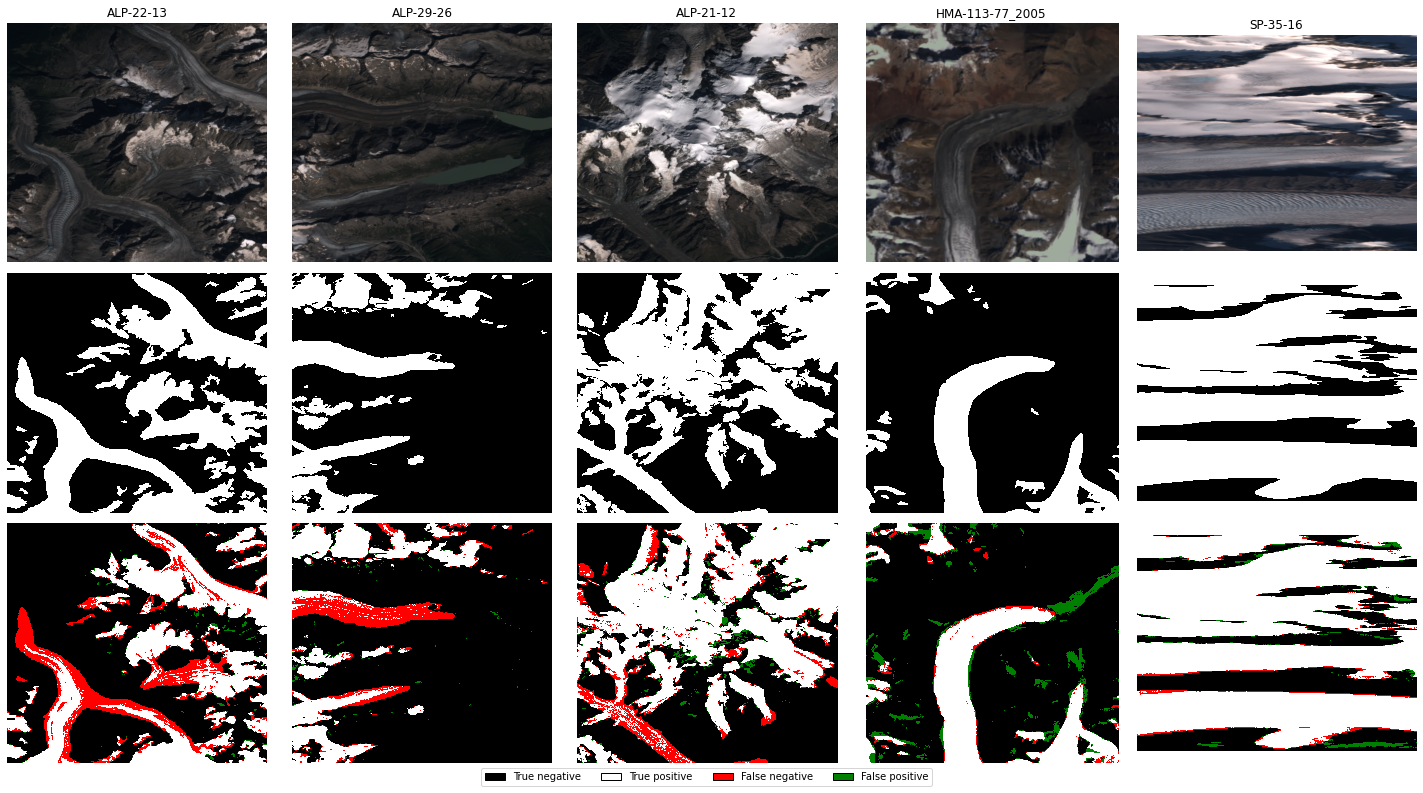

In [24]:
tiles_to_visualise = ["ALP-22-13", "ALP-29-26", "ALP-21-12", "HMA-113-77_2005", "SP-35-16"]

nrows, ncols = 3, len(tiles_to_visualise)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 3.6*nrows))

for col, tile in enumerate(tiles_to_visualise):
    rgb = np.array(test_dataset[tile]["optical"])[:, :, [2, 1, 0]]
    
    axes[0][col].set_title(tile)
    axes[0][col].imshow(rgb, vmin=0., vmax=0.3)
    
    groundtruth = np.array(test_dataset[tile]["groundtruth"])[:, :, 0]
    axes[1][col].imshow(groundtruth, cmap="gray", interpolation="none")
    
    output_colors = ["black", "white", "red", "green"]
    output_cmap = mpl.colors.ListedColormap(output_colors, 4)
      
    predicted = results[tile]
    output = np.zeros(predicted.shape)
    output[(predicted == 1) & (groundtruth == 1)] = 1
    output[(predicted == 0) & (groundtruth == 1)] = 2
    output[(predicted == 1) & (groundtruth == 0)] = 3
    axes[2][col].imshow(output / 3, cmap=output_cmap, interpolation="none")

for row in range(nrows):
    for col in range(ncols):
        axes[row][col].axis("off")
    
labels = ["True negative", "True positive", "False negative", "False positive"]
handles = [mpl.patches.Patch(facecolor=_, edgecolor="black") for _ in output_colors]

fig.legend(handles, labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.022))

plt.tight_layout()
plt.show()

Clean after yourself a bit. :)

Usually it is not strictly necessary if you terminate your session properly, we left this cell just in case if it is really needed to close the dataset files at some point.

In [25]:
train_dataset.close()
val_dataset.close()
test_dataset.close()